In [ ]:
!pip install tensorflow torch_geometric stable-baselines3 shap gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import torch
import gym
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap
import random
import torch_geometric
from stable_baselines3 import DQN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/CICIDS2017.csv"  # Adjust the path to your dataset
df = pd.read_csv(dataset_path)
df.head()


Mounted at /content/drive


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
print(df.columns)  # List all column names

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces

In [ ]:
print(df.columns)  # Confirm that 'Label' exists correctly

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset (ensure this is uncommented when running)
# df = pd.read_csv("your_dataset.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Timestamp to datetime format
if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Drop unnecessary columns
df = df.drop(["Flow ID"], axis=1, errors='ignore')

# Handle missing/infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)  # Replace NaN only in numeric columns

# ---- Feature Engineering ---- #

# 1. **Packet Entropy Calculation**
def calculate_entropy(packet_sizes):
    value, counts = np.unique(packet_sizes, return_counts=True)
    probabilities = counts / len(packet_sizes)
    return -np.sum(probabilities * np.log2(probabilities))

if "Packet_Size" in df.columns:
    df["Packet_Entropy"] = df["Packet_Size"].rolling(5).apply(calculate_entropy, raw=True)

# 2. **Request Frequency (Requests per Second)**
if {"Source_IP", "Timestamp"}.issubset(df.columns):
    df["Request_Frequency"] = df.groupby("Source_IP")["Timestamp"].diff().dt.total_seconds().fillna(0)

# 3. **Unusual Device Behavior (Z-score normalization)**
if {"Device_ID", "Packet_Size"}.issubset(df.columns):
    df["Unusual_Device_Behavior"] = df.groupby("Device_ID")["Packet_Size"].transform(lambda x: (x - x.mean()) / x.std())

# ---- Label Encoding ---- #
if any(col.lower() == "label" for col in df.columns):
    le = LabelEncoder()
    df["Label"] = le.fit_transform(df["Label"])

    # Convert non-numeric columns to numeric (coercing errors)
    df = df.apply(pd.to_numeric, errors="coerce")

    # Normalize numerical features
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.drop(["Label"], axis=1))

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(df_scaled, df["Label"], test_size=0.2, random_state=42)

    print("Preprocessing completed successfully!")
else:
    raise KeyError("The column 'Label' is missing even after stripping spaces!")

# Display first few rows
df.head()

Preprocessing completed successfully!


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Reshape input for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define model (using GRU instead of LSTM for speed improvement)
model = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Faster than LSTM
    GRU(16, return_sequences=False),  # Reduce units for speed
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent unnecessary training
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
model.fit(X_train_reshaped, y_train, epochs=3, batch_size=32,
          validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

print("Training completed!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 500s 88ms/step - accuracy: 0.8690 - loss: 0.2540 - val_accuracy: 0.9785 - val_loss: 0.0710
Epoch 2/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 495s 86ms/step - accuracy: 0.9760 - loss: 0.0772 - val_accuracy: 0.9717 - val_loss: 0.0637
Epoch 3/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 506s 87ms/step - accuracy: 0.9801 - loss: 0.0596 - val_accuracy: 0.7349 - val_loss: 0.5272
Training completed!


Reinforcement Learning for Dynamic Firewall Rules

In [ ]:
class SecurityEnv(gym.Env):
    def __init__(self):
        super(SecurityEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)  # Attack, traffic anomaly, history
        self.action_space = gym.spaces.Discrete(3)  # 3 actions: Block, Rate-limit, No-action
        self.state = np.array([0.5, 0.5, 0.5])  # Initial state

    def step(self, action):
        reward = 0
        if action == 0:  # Block action
            reward = 1.0
        elif action == 1:  # Rate-limit action
            reward = 0.5
        elif action == 2:  # No action
            reward = -0.1  # Risk increases

        self.state = np.random.rand(3)  # New state (simulate dynamic changes)
        return self.state, reward, False, {}

    def reset(self):
        self.state = np.array([0.5, 0.5, 0.5])
        return self.state


In [ ]:
!pip install 'shimmy>=2.0'

In [ ]:
env = SecurityEnv()
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
obs = env.reset()
for _ in range(10):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f"Action Taken: {action}, Reward: {reward}")


Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 2, Reward: -0.1
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0
Action Taken: 0, Reward: 1.0


 Integrating Self-Healing: Docker Rollback

In [ ]:
import os

def rollback_container(container_name, snapshot_name):
    os.system(f"docker stop {container_name}")
    os.system(f"docker rm {container_name}")
    os.system(f"docker run --name {container_name} {snapshot_name}")
    print(f"Rolled back {container_name} to {snapshot_name}")


Feature Importance Visualization with SHAP

<Figure size 640x480 with 0 Axes>

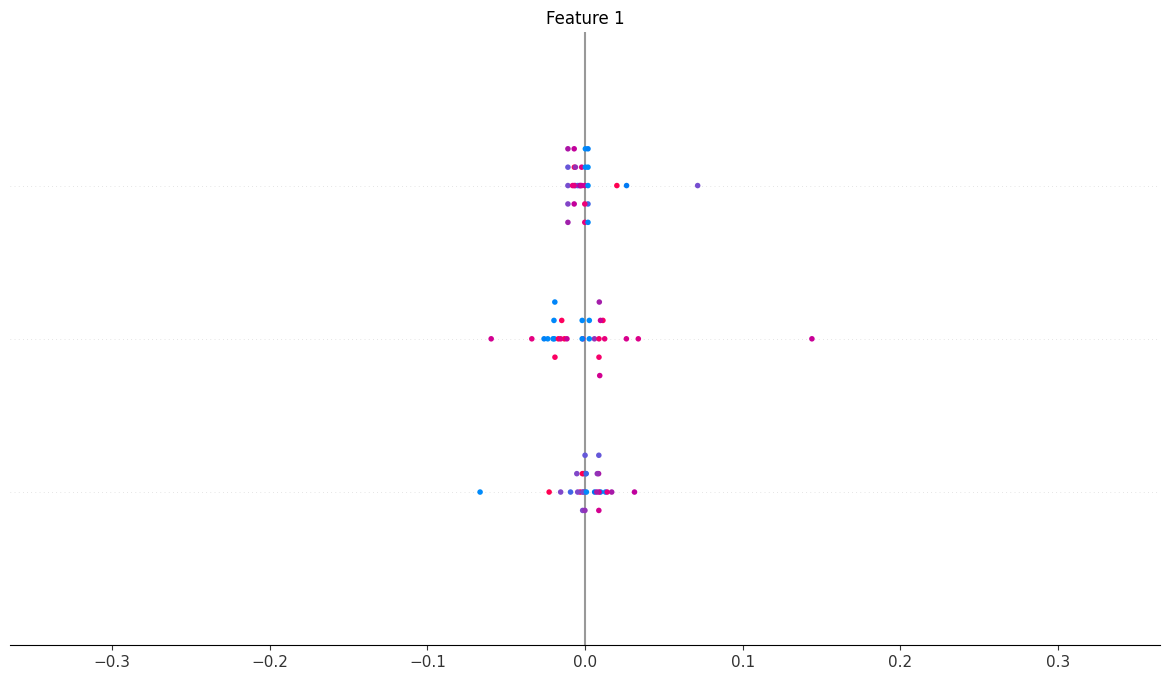

In [ ]:
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Example: Load a dataset and prepare the data
data = load_iris()
X = data.data
y = data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Now, use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Visualize the feature importance
shap.summary_plot(shap_values, X_test)



In [ ]:
model.save('model/model.h5')

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'model' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load sample dataset (replace this with your dataset)
data = load_iris()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Check if the model is properly defined
print(type(rf))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import joblib

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Save the trained model
model_filename = "rf_model.pkl"
joblib.dump(rf, model_filename)

# Download the model (if in Google Colab)
from google.colab import files
files.download(model_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>